In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

def generer_zeros_2(nbr_x, nbr_y):
    return np.zeros((nbr_x, nbr_y))

def generer_uns_2(nbr_x, nbr_y):
    return np.ones((nbr_x, nbr_y))

def generer_aleatoire_2(nbr_x, nbr_y):
    return np.random.rand(nbr_x, nbr_y)

def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std


def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = (X - mean)/std
    return X_norm, mean, std

def z_n(X, Theta): 
    return np.dot(X, Theta.T)

def softmax(X):
    e = np.exp(X)
    return  (e.T / np.sum(e, axis=1)).T

def h_n(X, Theta_n, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return softmax(z_n(X_pre, Theta_n))

def J_n(H, Y): 
    return - np.mean(np.sum(Y * np.log(H), axis=1))

def gradient_n(X, H, Y):
    error = (H-Y)/X.shape[0]
    return  np.dot(X.T, error).T

def entrainer_n(X, Y, norm=True, const=True, nbr_iter=200, alpha=1., eps=0.01, 
                theta_func=generer_zeros_2, h_func=h_n, J_func=J_n, grad_func=gradient_n):
    
    X_pre, mean, std = preparer(X, norm=norm, const=const)
    
    Theta = theta_func(Y.shape[1], X_pre.shape[1])
    
    couts = []
    couts.append(J_func(h_func(X_pre, Theta), Y))
    
    for i in range(nbr_iter):
        H = h_func(X_pre, Theta)
        Theta -= alpha * grad_func(X_pre, H, Y)
        couts.append(J_func(H, Y))
    
    return Theta, mean, std, couts


def predire_n(H): 
    return (H == np.max(H, axis=1).reshape(-1, 1)).astype(int)


class MaxEnt(object):
    
    def __init__(self, nbr_iter=100, alpha=1., theta_func=generer_zeros_2, norm=True, const=True): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.theta_func = theta_func
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y): 
        #encoder = OneHotEncoder(sparse=False)
        #self.yencoder = encoder.fit(Y)
        # Y = self.yencoder.transform(Y)
        self.Theta, self.mean, self.std, self.couts = entrainer_n(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  theta_func=self.theta_func, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=True, seuil=0.5):
        H = h_n(X, self.Theta, self.mean, self.std, self.const)
        if prob:
            return H
        return predire_n(H, seuil=seuil)
    
    

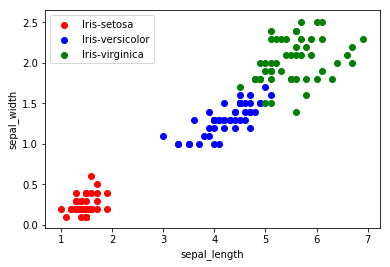

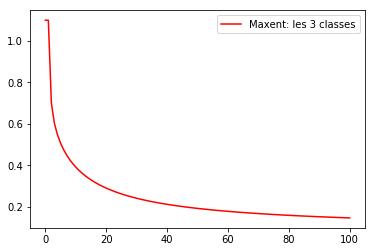

In [2]:
iris = pd.read_csv("datasets/iris.csv")
iris = iris.sample(frac=1)

if iris.shape[1] > 3:
    iris.drop(["sepal_length", "sepal_width"], axis = 1, inplace=True)
iris.head()


X_iris = iris.iloc[:, :-1].values # Premières colonnes 
Y_iris = iris.iloc[:,-1].values # Dernière colonne 

#--------------afichage des donnees--------------------------------------------------------------------
setosa = iris["class"] == "Iris-setosa"
versicolor = iris["class"] == "Iris-versicolor"
virginica = iris["class"] == "Iris-virginica"

plt.scatter(X_iris[setosa, 0], X_iris[setosa, 1], color="red", label="Iris-setosa")
plt.scatter(X_iris[versicolor, 0], X_iris[versicolor, 1], color="blue", label="Iris-versicolor")
plt.scatter(X_iris[virginica, 0], X_iris[virginica, 1], color="green", label="Iris-virginica")

plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.legend()
plt.show()
#-------------------------------------------------------------------------------------------

iris_msk = np.random.rand(len(X_iris)) < 0.8 
X_iris_train = np.array(X_iris[iris_msk, :], dtype=np.float32)
X_iris_test = np.array(X_iris[~iris_msk, :], dtype=np.float32)



iris["class"].value_counts()
# Encodage des classes (ta3 1 et 0)
Y_iris_setosa = (Y_iris == "Iris-setosa").astype(int)
Y_iris_versicolor = (Y_iris == "Iris-versicolor").astype(int)
Y_iris_virginica = (Y_iris == "Iris-virginica").astype(int)

Y_iris_setosa_test = np.array(Y_iris_setosa[~iris_msk], dtype=np.float32)
Y_iris_versicolor_test = np.array(Y_iris_versicolor[~iris_msk], dtype=np.float32) * 2
Y_iris_virginica_test = np.array(Y_iris_virginica[~iris_msk], dtype=np.float32) * 3

Y_iris_test = Y_iris_setosa_test + Y_iris_versicolor_test + Y_iris_virginica_test 

Y_iris_setosa_train = np.array(Y_iris_setosa[iris_msk], dtype=np.float32)
Y_iris_versicolor_train = np.array(Y_iris_versicolor[iris_msk], dtype=np.float32)
Y_iris_virginica_train = np.array(Y_iris_virginica[iris_msk], dtype=np.float32)

Y_iris_onehot_train = np.column_stack((Y_iris_setosa_train, Y_iris_versicolor_train, Y_iris_virginica_train))

maxent_iris = MaxEnt()
maxent_iris.entrainer(X_iris_train, Y_iris_onehot_train)

plt.plot(maxent_iris.couts, color="red", label="Maxent: les 3 classes")
plt.legend()
plt.show()

In [3]:
#test

iris_maxent_prob = maxent_iris.predire(X_iris_test)

# encodage des sorties en 1, 2, 3
iris_maxent_test = np.argmax(iris_maxent_prob, axis=1) + 1


from sklearn.metrics import classification_report
noms_classes = ["setosa", "versicolor", "virginica"]

print("En utilisant 1 modèle de régression multinomiale")
print(classification_report(Y_iris_test, iris_maxent_test, target_names=noms_classes))

En utilisant 1 modèle de régression multinomiale
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.75      0.86         4
   virginica       0.90      1.00      0.95         9

    accuracy                           0.96        28
   macro avg       0.97      0.92      0.93        28
weighted avg       0.97      0.96      0.96        28

